In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import pathlib
import time
import json
import pandas as pd
from IPython.display import display
from urllib.request import urlopen
import matplotlib.pyplot as plt

# Pandas

In this notebook we will explore the pandas Python library, and how it can speed up data analysis.

# Table of contents
1. [Defining Data](#defining-data)
2. [Loading Data](#loading-data)
3. [Examining Data](#examining-data)
4. [Selecting Data](#selecting-data)
    1. [Series Object](#series-object)
    2. [Series Data](#series-data)
    3. [Index Definition](#index-definition)
    4. [Selecting Data by Column](#selecting-data-by-column)
    5. [Selecting Data by Row](#selecting-data-by-row)
5. [Create Significant Events](#create-significant-events)
    1. [Removing Missing Data](#removing-missing-data)
    2. [Select Rows by Multiple Criteria](#select-rows-by-multiple-criteria)
6. [Saving Results](#saving-results)
7. [Plotting Results](#plotting-results)
8. [Working with String Data](#working-with-string-data)
9. [Applying Functions to Data](#applying-functions-to-data)
10. [Resources](#resources)

## Defining Data  <a name="defining-data"></a>

Philosophically, the term "data" is heavily overloaded:

 - To a scientist, data can mean raw information collected by a human or instrument in the lab or field
 - To a programmer, who lives in a binary world, data are those bits of information that are NOT CODE.
 - To a GIS analyst, data is **geospatial data** - vectors and rasters.
 - To a business analyst, data can mean (sometimes sensitive) information collected about customers

When we talk about "data" in the context of this tutorial, we are talking about two-dimensional tabular information, like you would see in a spreadsheet or CSV file. These data could be data collected in the field, the results of a model, the results of a geospatial analysis, or information about customers that may be sensitive or be subject to privacy concerns.

## Loading Data <a name="loading-data"></a>

pandas provides a number of methods for getting data into our structure of primary interest, the *dataframe*.

 - Excel
 - CSV/tab separated/other delimiter
 - Relational Databases (MySQL, SQLite, etc)
 - Fixed width format data
 - Manual creation
 
 I've written a function here to grab product "properties" from ComCat, using it's API. The function saves these 
 results in a CSV. We'll load that CSV file into a dataframe.

In [3]:
events_file = 'events_2020_properties.csv'

In [4]:
def get_properties_dataframe(starttime, endtime, products, 
                             minmag=5.5, maxmag=9.9):
    '''
    Download product properties for input products.
    
    Args:
        starttime (datetime): Python datetime for search start time.
        endtime (datetime): Python datetime for search end time.
        products (list): List of strings of valid ComCat product types 
                        ('shakemap', 'losspager', 'dyfi', 'finite-fault')
        minmag (float): Minimum magnitude for search.
        maxmag (float): Maximum magnitude for search.
    Returns:
        dataframe: pandas Dataframe with fixed columns:
                   - eventid
                   - time
                   - location
                   - latitude
                   - longitude
                   - depth
                   - magnitude
                   
                   and then any number of variable columns of the different product properties.
    '''
    TIMEFMT = '%Y-%m-%dT%H:%M:%S'
    starttime_str = starttime.strftime(TIMEFMT)
    endtime_str = endtime.strftime(TIMEFMT)
    url = ('https://earthquake.usgs.gov/fdsnws/event/1/query?'
           f'format=geojson&starttime={starttime_str}&'
           f'endtime={endtime_str}&orderby=time-asc&'
           f'minmagnitude={minmag}&maxmagnitude={maxmag}')
    with urlopen(url) as fh:
        data = fh.read().decode('utf8')
    jdict = json.loads(data)
    rows = []
    for feature in jdict['features']:
        row = {}    
        types = feature['properties']['types'].split(',')[1:-1]
        ptypes = set(products) & set(types) # types we want intersected w/ what we have
        if not len(ptypes):
            mag = feature['properties']['mag']
            continue
        detail_url = feature['properties']['detail']
        with urlopen(detail_url) as fh:
            data = fh.read().decode('utf8')
        detail = json.loads(data)
        row['eventid'] = detail['id']
        
        # get event time from Unix timestamp in milliseconds
        dtime = detail['properties']['time']
        row['time'] = datetime.utcfromtimestamp(dtime/1000)
        
        row['location'] = detail['properties']['place']
        row['latitude'] = detail['geometry']['coordinates'][1]
        row['longitude'] = detail['geometry']['coordinates'][0]
        row['depth'] = detail['geometry']['coordinates'][2]
        row['magnitude'] = detail['properties']['mag']
        
        for ptype in ptypes:
            product = detail['properties']['products'][ptype][0]
            for pkey in product['properties']:
                key = f'{ptype}-{pkey}'
                value = product['properties'][pkey]
                try:
                    value = int(value)
                except:
                    try:
                        value = float(value)
                    except:
                        pass
                if value == 'None':
                    value = float('nan')
                row[key] = value
        rows.append(row)
    dataframe = pd.DataFrame(rows)
    return dataframe

Let's retrieve a local file, if it exists. We'll show the first five rows of the dataframe when we're done. Note that there are a *lot* of columns, probably more than we need.

In [5]:
if not pathlib.Path(events_file).exists():
    t1=time.time()
    products = ['shakemap', 'losspager', 'dyfi']
    starttime = datetime(2020, 1, 1)
    endtime = datetime(2021, 1, 1)
    props = get_properties_dataframe(starttime, endtime, products, minmag=5.5)
    t2 = time.time()
    dt2 = t2-t1
    print(f'{dt2:.1f} seconds to retrieve dataframe')
    pd.set_option('display.max_columns', None)
    # save the props dataframe to csv
    props.to_csv(events_file, index=False)
else:
    props = pd.read_csv(events_file, sep=',', header=0, parse_dates=['time'])
props.head()

,eventid,time,location,latitude,longitude,depth,magnitude,shakemap-depth,shakemap-event-description,shakemap-event-type,...,dyfi-longitude,dyfi-magnitude,dyfi-maxmmi,dyfi-num-responses,dyfi-numResp,dyfi-original-signature,dyfi-original-signature-version,dyfi-pdl-client-version,shakemap-overlayHeight,shakemap-overlayWidth
0,us70006tev,2020-01-02 04:29:06.582,"81 km SW of T?yb?d, Iran",34.1326,60.2681,10.00,5.5,10.0,USGS NEIC ShakeMap,ACTUAL,...,60.2681,5.5,4.8,6.0,6.0,MCwCFCeh/3nsulHyeBmafqkEzfIG/pVBAhRZuVLynAspbW...,v1,Version 2.4.0 2020-05-11,NaN,NaN
1,us70006thw,2020-01-02 11:25:04.368,"287 km ESE of Katabu, Indonesia",-5.7527,124.9760,10.00,5.6,10.0,USGS NEIC ShakeMap,ACTUAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,us70006ttf,2020-01-02 18:23:53.135,"38 km ENE of Hasaki, Japan",35.8098,141.2490,31.00,5.7,31.0,USGS NEIC ShakeMap,ACTUAL,...,141.2462,5.6,4.5,133.0,133.0,MCwCFGZ+1Y+dFHK/nxCieu2QkuIVtXo0AhQgwky7+6L1Gf...,v1,Version 2.1.0 2019-03-07,NaN,NaN
3,us70006u7m,2020-01-03 15:28:54.137,"7 km W of Santa Teresa, Nicaragua",11.7392,-86.2862,106.87,5.5,106.9,USGS NEIC ShakeMap,ACTUAL,...,-86.2978,5.5,4.2,62.0,62.0,MC4CFQDj+8oEcyr0+BxbDuEyLrwrke4Q3AIVAKOp3Pc4iH...,v1,Version 2.1.0 2019-03-07,NaN,NaN
4,us70006uwq,2020-01-05 04:40:49.332,"3 km W of Reforma de Pineda, Mexico",16.4011,-94.4890,87.00,5.9,87.0,USGS NEIC ShakeMap,ACTUAL,...,-94.4890,5.9,5.9,98.0,98.0,MC4CFQDHMEe56C+KOhR29qr/WWaZ075s/AIVAK7gkwBiib...,v1,Version 2.7.9 2021-02-10,NaN,NaN


## Examining Data <a name="examining-data"></a>

In [6]:
# Get the size of the dataframe
# props.shape
# len(props)

# look at the columns
# props.columns

# look at the indices
# props.index

# Look at the whole data set
# props

# Look at a subset of the data (by row)
# props.head(5)

## Selecting Data <a name="selecting-data"></a>

There are multiple ways to select data from a DataFrame in either dimension. Here we'll explain a few of these methods and explain some important attributes along the way.

###  Series Object <a name="series-object"></a>

A pandas DataFrame, as we've seen is made up of rows and columns of data, like a spreadsheet. You might be wondering what data structure is returned if you extract a single column or row. The answer is a **Series** object, which is interesting in it's own right for time series analysis, as just one example.

In [7]:
magnitudes = props['magnitude']
magnitudes

0      5.5
1      5.6
2      5.7
3      5.5
4      5.9
      ... 
399    6.7
400    5.7
401    5.7
402    6.4
403    5.7
Name: magnitude, Length: 404, dtype: float64

### Series Data <a name="series-data"></a>

A Series object is a wrapper around a numpy array, and it implements many of the same basic functions as a numpy array. This numpy array is accessible through the Series `values` property.

In [8]:
print(f'Magnitudes sum: {magnitudes.sum():.2f}')
print(f'Magnitudes mean: {magnitudes.mean():.2f}')
print(f'Magnitudes std: {magnitudes.std():.2f}')
print(f'Magnitudes min: {magnitudes.min():.2f}')
print(f'Magnitudes max: {magnitudes.max():.2f}')
print(f'Magnitudes array: {magnitudes.values}')

Magnitudes sum: 2366.68
Magnitudes mean: 5.86
Magnitudes std: 0.39
Magnitudes min: 5.50
Magnitudes max: 7.80
Magnitudes array: [5.5  5.6  5.7  5.5  5.9  5.6  5.8  6.3  6.4  5.6  5.6  6.   5.5  6.4
 5.6  5.9  5.6  5.7  5.6  5.8  6.   6.   6.1  6.1  5.5  5.5  5.5  5.6
 6.2  5.5  5.5  6.7  5.6  6.1  5.8  5.7  6.3  5.5  5.5  7.7  6.1  6.
 5.8  5.5  5.7  5.9  5.7  5.6  5.8  6.2  6.   5.5  5.6  6.   6.1  5.5
 7.   5.6  5.7  5.6  5.5  5.8  5.6  5.5  5.8  6.   6.   5.5  5.7  5.7
 5.5  6.   5.5  5.77 5.6  5.7  5.5  6.4  5.8  5.6  6.   6.1  5.5  5.7
 6.2  5.5  5.7  5.5  5.7  5.6  6.1  5.5  7.5  6.1  5.7  5.6  5.9  5.8
 5.7  5.6  6.5  5.5  5.5  6.   5.5  5.9  6.1  6.   5.7  5.7  6.1  5.9
 5.8  6.6  5.7  6.3  5.5  6.1  6.5  5.7  5.9  5.6  5.5  6.8  6.1  5.5
 5.8  5.7  6.6  5.7  6.5  5.7  5.6  5.9  5.7  5.7  6.1  5.5  5.8  5.6
 5.5  6.2  6.   5.8  5.5  5.6  5.6  6.1  5.8  6.8  6.   5.7  5.51 6.4
 5.7  5.8  5.7  5.9  5.7  5.5  5.7  5.9  6.   5.7  6.6  6.2  5.9  5.5
 5.6  5.5  5.6  7.4  5.5  5.5  5.6

### Index Definition <a name="index-definition"></a>

In the same way that a column name identifies a *column*, an index is a way to uniquely identify a *row*. 

Indices might be the following things:

 - In **medicine**, an index might be a patient ID
 - In **business**, an index might be an invoice ID, or a customer ID
 - In **seismology**, an index might be the ComCat ID, or a seismic station ID.
 
That being said, I tend not to use the index capability, because searching for rows based on specific criteria is typically a more useful approach - few people internalize or remember ComCat IDs, and you may very easily have more than one row with the same seismic station in your dataset.

### Selecting Data by Column <a name="selecting-data-by-column"></a>

You can select data from one or more dataframe columns, or one or more rows. Row selection can be done in a few different ways.

In [9]:
# selecting by columns
keep_columns = ['eventid', 'time', 
                'latitude', 'longitude', 
                'depth', 'magnitude'
               ]
props[keep_columns]

,eventid,time,latitude,longitude,depth,magnitude
0,us70006tev,2020-01-02 04:29:06.582,34.1326,60.2681,10.00,5.5
1,us70006thw,2020-01-02 11:25:04.368,-5.7527,124.9760,10.00,5.6
2,us70006ttf,2020-01-02 18:23:53.135,35.8098,141.2490,31.00,5.7
3,us70006u7m,2020-01-03 15:28:54.137,11.7392,-86.2862,106.87,5.5
4,us70006uwq,2020-01-05 04:40:49.332,16.4011,-94.4890,87.00,5.9
...,...,...,...,...,...,...
399,us6000d3i9,2020-12-27 21:39:14.770,-39.3398,-74.9849,10.00,6.7
400,us6000d3kl,2020-12-28 04:32:20.070,-47.5074,99.9538,10.00,5.7
401,us6000d3xn,2020-12-29 07:10:29.079,43.3890,-126.9951,10.00,5.7
402,us6000d3zh,2020-12-29 11:19:54.762,45.4244,16.2573,10.00,6.4


### Selecting Data by Row <a name="selecting-data-by-row"></a>

You can select data by row in three different ways:

 - Select by index
 - Select by row location
 - Select by column criteria
 
 In order to demonstrate that the row **index** can be different than row **location**, I'll go out of order and create a subset of data first by selecting events with at least a magnitude of 7.5. Later we'll go into more detail on selecting data from rows.

In [10]:
# select by simple criteria
mag_criteria = props['magnitude'] >= 7.5
subframe = props[mag_criteria]
subframe

,eventid,time,location,latitude,longitude,depth,magnitude,shakemap-depth,shakemap-event-description,shakemap-event-type,...,dyfi-longitude,dyfi-magnitude,dyfi-maxmmi,dyfi-num-responses,dyfi-numResp,dyfi-original-signature,dyfi-original-signature-version,dyfi-pdl-client-version,shakemap-overlayHeight,shakemap-overlayWidth
39,us60007idc,2020-01-28 19:10:24.918,"123 km NNW of Lucea, Jamaica",19.4193,-78.7560,14.86,7.7,14.9,USGS NEIC ShakeMap,ACTUAL,...,-78.7560,7.7,9.0,1540.0,1540.0,MC0CFQCzjcUP/7seAkxpLUqvlfrUKDdk+QIUN06565rv2L...,v1,Version 2.4.0 2020-05-11,NaN,NaN
92,us70008fi4,2020-03-25 02:49:21.160,"221 km SSE of Severo-Kuril’sk, Russia",48.9638,157.6955,57.80,7.5,57.8,USGS NEIC ShakeMap,ACTUAL,...,157.6914,7.5,5.6,27.0,27.0,MC0CFQCxnRusD0dgJCqw+iaZBXgaik5/LgIUR2CXcLsnqX...,v1,Version 2.1.0 2019-03-07,NaN,NaN
204,us7000asvb,2020-07-22 06:12:44.810,"99 km SSE of Perryville, Alaska",55.0715,-158.5960,28.00,7.8,28.0,USGS NEIC ShakeMap,ACTUAL,...,-158.5960,7.8,7.1,301.0,301.0,MCwCFGByNWdbJboVijmFfEuSFEiOJNL1AhRsIj8KtjHLQs...,v1,Version 2.4.0 2020-05-11,NaN,NaN
324,us6000c9hg,2020-10-19 20:54:38.950,"99 km SE of Sand Point, Alaska",54.6020,-159.6258,28.37,7.6,28.4,USGS NEIC ShakeMap,ACTUAL,...,-159.6258,7.6,8.6,321.0,321.0,MC0CFBBy9v5+ikFzJDhZNNjNLYEmz3MVAhUA4qFe+VMX05...,v1,Version 2.7.9 2021-02-10,NaN,NaN


Note that the rows in this data subset retained their index. Now let's select rows from this subset by that *index*.

In [11]:
subframe.loc[[39,92]]

,eventid,time,location,latitude,longitude,depth,magnitude,shakemap-depth,shakemap-event-description,shakemap-event-type,...,dyfi-longitude,dyfi-magnitude,dyfi-maxmmi,dyfi-num-responses,dyfi-numResp,dyfi-original-signature,dyfi-original-signature-version,dyfi-pdl-client-version,shakemap-overlayHeight,shakemap-overlayWidth
39,us60007idc,2020-01-28 19:10:24.918,"123 km NNW of Lucea, Jamaica",19.4193,-78.7560,14.86,7.7,14.9,USGS NEIC ShakeMap,ACTUAL,...,-78.7560,7.7,9.0,1540.0,1540.0,MC0CFQCzjcUP/7seAkxpLUqvlfrUKDdk+QIUN06565rv2L...,v1,Version 2.4.0 2020-05-11,NaN,NaN
92,us70008fi4,2020-03-25 02:49:21.160,"221 km SSE of Severo-Kuril’sk, Russia",48.9638,157.6955,57.80,7.5,57.8,USGS NEIC ShakeMap,ACTUAL,...,157.6914,7.5,5.6,27.0,27.0,MC0CFQCxnRusD0dgJCqw+iaZBXgaik5/LgIUR2CXcLsnqX...,v1,Version 2.1.0 2019-03-07,NaN,NaN


Select rows from this subset by row *location*

In [12]:
subframe.iloc[0:2]

,eventid,time,location,latitude,longitude,depth,magnitude,shakemap-depth,shakemap-event-description,shakemap-event-type,...,dyfi-longitude,dyfi-magnitude,dyfi-maxmmi,dyfi-num-responses,dyfi-numResp,dyfi-original-signature,dyfi-original-signature-version,dyfi-pdl-client-version,shakemap-overlayHeight,shakemap-overlayWidth
39,us60007idc,2020-01-28 19:10:24.918,"123 km NNW of Lucea, Jamaica",19.4193,-78.7560,14.86,7.7,14.9,USGS NEIC ShakeMap,ACTUAL,...,-78.7560,7.7,9.0,1540.0,1540.0,MC0CFQCzjcUP/7seAkxpLUqvlfrUKDdk+QIUN06565rv2L...,v1,Version 2.4.0 2020-05-11,NaN,NaN
92,us70008fi4,2020-03-25 02:49:21.160,"221 km SSE of Severo-Kuril’sk, Russia",48.9638,157.6955,57.80,7.5,57.8,USGS NEIC ShakeMap,ACTUAL,...,157.6914,7.5,5.6,27.0,27.0,MC0CFQCxnRusD0dgJCqw+iaZBXgaik5/LgIUR2CXcLsnqX...,v1,Version 2.1.0 2019-03-07,NaN,NaN


## Create Significant Events <a name="create-significant-events"></a>

Let's select down from all of these product properties some that are interesting for further analysis. Here we're selecting the following columns:

 - **shakemap-maxmmi** The maximum Mercalli intensity for an event as modeled by ShakeMap
 - **losspager-alertlevel** The PAGER alert level (Green, Yellow, Orange, Red) assigned to the event
 - **dyfi-num-responses** The number of DYFI responses that came in from users

In [13]:
keep_columns = ['eventid', 'time', 
                'latitude', 'longitude', 
                'depth', 'magnitude', 
                'shakemap-maxmmi', 'losspager-alertlevel',
                'dyfi-num-responses'
               ]
sprops = props[keep_columns]
sprops.head()

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
0,us70006tev,2020-01-02 04:29:06.582,34.1326,60.2681,10.00,5.5,6.842,green,6.0
1,us70006thw,2020-01-02 11:25:04.368,-5.7527,124.9760,10.00,5.6,3.741,green,NaN
2,us70006ttf,2020-01-02 18:23:53.135,35.8098,141.2490,31.00,5.7,4.110,green,133.0
3,us70006u7m,2020-01-03 15:28:54.137,11.7392,-86.2862,106.87,5.5,3.486,green,62.0
4,us70006uwq,2020-01-05 04:40:49.332,16.4011,-94.4890,87.00,5.9,4.663,green,98.0


### Removing Missing Data <a name="removing-missing-data"></a>

Notice above that some earthquakes do not have all columns set to real values - where this occurs, pandas inserts *NaN* values. pandas provides a method to allow us to remove rows with NaNs present in any of the columns. Let's remove all the rows where *any* of our properties of interest is set to NaN.

In [14]:
# clean up events that do not have DYFI or PAGER results
print(f'Events before filter: {len(sprops)}')
columns = ['losspager-alertlevel', 'dyfi-num-responses', 'shakemap-maxmmi']
sprops = sprops.dropna(subset=columns)
print(f'Events after filter: {len(sprops)}')
sprops.head()

Events before filter: 404
Events after filter: 212


,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
0,us70006tev,2020-01-02 04:29:06.582,34.1326,60.2681,10.00,5.5,6.842,green,6.0
2,us70006ttf,2020-01-02 18:23:53.135,35.8098,141.2490,31.00,5.7,4.110,green,133.0
3,us70006u7m,2020-01-03 15:28:54.137,11.7392,-86.2862,106.87,5.5,3.486,green,62.0
4,us70006uwq,2020-01-05 04:40:49.332,16.4011,-94.4890,87.00,5.9,4.663,green,98.0
6,pr2020006006,2020-01-06 10:32:18.770,17.8675,-66.8193,6.00,5.8,6.356,yellow,936.0


### Select Rows by Multiple Criteria <a name="select-rows-by-multiple-criteria"></a>

Selecting rows based on single or multiple column criteria will be a common goal. Imagine that we want to select down a list of "significant" events from 2020, based on four criteria:

 - **Magnitude** >= 7.0
 - **Maximum MMI** >= 7.0
 - **Number of DYFI Responses** >= 100
 - **PAGER Alert Level** >= Yellow
 
 We'll go through each of these in turn, and then see how to combine them to create our dataset of significant events.

In [15]:
condition_magnitude = sprops['magnitude'] >= 6.0
sprops.loc[condition_magnitude].head()

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
7,us70006vkq,2020-01-07 06:05:19.759,2.3481,96.3575,17.00,6.3,6.331,green,13.0
8,us70006vll,2020-01-07 08:24:25.262,17.8686,-66.8266,8.95,6.4,7.569,orange,1732.0
11,us70006vvr,2020-01-07 19:11:35.665,-5.2046,151.2659,117.00,6.0,4.364,green,2.0
20,us60007a3h,2020-01-18 16:38:14.301,-2.8405,139.3363,44.00,6.0,5.514,green,3.0
21,us60007anp,2020-01-19 13:27:56.630,39.8353,77.1084,5.55,6.0,7.579,orange,9.0


What does this condition look like? It turns out it is a **Series** object with boolean values at each index. 

In [16]:
condition_magnitude

0      False
2      False
3      False
4      False
6      False
       ...  
397    False
398    False
399     True
401    False
402     True
Name: magnitude, Length: 212, dtype: bool

In [17]:
condition_maxmmi = sprops['shakemap-maxmmi'] >= 6.0
sprops.loc[condition_maxmmi].head()

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
0,us70006tev,2020-01-02 04:29:06.582,34.1326,60.2681,10.00,5.5,6.842,green,6.0
6,pr2020006006,2020-01-06 10:32:18.770,17.8675,-66.8193,6.00,5.8,6.356,yellow,936.0
7,us70006vkq,2020-01-07 06:05:19.759,2.3481,96.3575,17.00,6.3,6.331,green,13.0
8,us70006vll,2020-01-07 08:24:25.262,17.8686,-66.8266,8.95,6.4,7.569,orange,1732.0
10,pr2020007010,2020-01-07 11:18:43.540,18.0223,-66.7760,9.00,5.6,6.611,yellow,152.0


In [18]:
condition_numresp = sprops['dyfi-num-responses'] > 100
sprops.loc[condition_numresp].head()

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
2,us70006ttf,2020-01-02 18:23:53.135,35.8098,141.2490,31.00,5.7,4.110,green,133.0
6,pr2020006006,2020-01-06 10:32:18.770,17.8675,-66.8193,6.00,5.8,6.356,yellow,936.0
8,us70006vll,2020-01-07 08:24:25.262,17.8686,-66.8266,8.95,6.4,7.569,orange,1732.0
10,pr2020007010,2020-01-07 11:18:43.540,18.0223,-66.7760,9.00,5.6,6.611,yellow,152.0
15,pr2020011010,2020-01-11 12:54:45.910,17.9490,-66.8508,5.00,5.9,6.598,yellow,974.0


In [19]:
condition_yellow = sprops['losspager-alertlevel'].str.match('yellow')
condition_orange = sprops['losspager-alertlevel'].str.match('orange')
condition_red = sprops['losspager-alertlevel'].str.match('red')

# you can combine these conditions with "and" or "or" conditions
combined_condition = condition_yellow | condition_orange | condition_red
sprops.loc[combined_condition].head()

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
6,pr2020006006,2020-01-06 10:32:18.770,17.8675,-66.8193,6.00,5.8,6.356,yellow,936.0
8,us70006vll,2020-01-07 08:24:25.262,17.8686,-66.8266,8.95,6.4,7.569,orange,1732.0
10,pr2020007010,2020-01-07 11:18:43.540,18.0223,-66.7760,9.00,5.6,6.611,yellow,152.0
15,pr2020011010,2020-01-11 12:54:45.910,17.9490,-66.8508,5.00,5.9,6.598,yellow,974.0
21,us60007anp,2020-01-19 13:27:56.630,39.8353,77.1084,5.55,6.0,7.579,orange,9.0


In [20]:
condition_alert = sprops['losspager-alertlevel'].isin(['yellow', 'orange', 'red'])
sprops.loc[condition_alert].head()

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
6,pr2020006006,2020-01-06 10:32:18.770,17.8675,-66.8193,6.00,5.8,6.356,yellow,936.0
8,us70006vll,2020-01-07 08:24:25.262,17.8686,-66.8266,8.95,6.4,7.569,orange,1732.0
10,pr2020007010,2020-01-07 11:18:43.540,18.0223,-66.7760,9.00,5.6,6.611,yellow,152.0
15,pr2020011010,2020-01-11 12:54:45.910,17.9490,-66.8508,5.00,5.9,6.598,yellow,974.0
21,us60007anp,2020-01-19 13:27:56.630,39.8353,77.1084,5.55,6.0,7.579,orange,9.0


Finally, we can combine all of these conditions together, creating a list of significant events from 2020.

In [21]:
# combine them all together
# recall: M >= 6 OR maxmmi >= 6 OR NumResp >= 100 OR Alert > GREEN
combined_condition = condition_magnitude & condition_maxmmi & condition_numresp & condition_alert
significant = sprops.loc[combined_condition]
significant

,eventid,time,latitude,longitude,depth,magnitude,shakemap-maxmmi,losspager-alertlevel,dyfi-num-responses
8,us70006vll,2020-01-07 08:24:25.262,17.8686,-66.8266,8.95,6.4,7.569,orange,1732.0
31,us60007ewc,2020-01-24 17:55:14.147,38.4312,39.0609,10.00,6.7,9.294,orange,313.0
39,us60007idc,2020-01-28 19:10:24.918,19.4193,-78.7560,14.86,7.7,6.000,yellow,1540.0
180,us6000ah9t,2020-06-23 15:29:04.350,15.8861,-96.0077,20.00,7.4,8.798,orange,636.0
244,us6000bgbr,2020-08-18 00:03:48.566,12.0257,124.1272,10.00,6.6,8.244,yellow,200.0
324,us6000c9hg,2020-10-19 20:54:38.950,54.6020,-159.6258,28.37,7.6,6.870,yellow,321.0
345,us7000c7y0,2020-10-30 11:51:27.348,37.8973,26.7838,21.00,7.0,7.044,orange,687.0
402,us6000d3zh,2020-12-29 11:19:54.762,45.4244,16.2573,10.00,6.4,8.623,orange,1824.0


In [22]:
len(significant)

8

## Saving Results <a name="saving-results"></a>

In [23]:
# index=False indicates that we do not want to save the index "column" to the output format. Feel free to keep 
# the index if it is useful in your work.
significant.to_csv('significant_events_2020.csv', index=False)
significant.to_excel('significant_events_2020.xlsx', index=False)

## Plotting Results <a name="plotting-results"></a>

pandas also incorporates matplotlib plotting capabilities within it, so it is possible to make a number of plots from your dataset without calling matplotlib functions directly.

Text(1.0, 175, 'N=212')

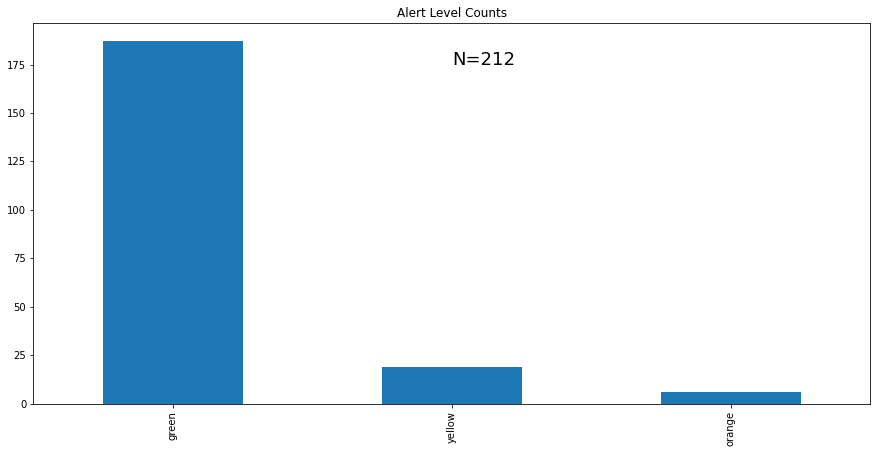

In [24]:
# sprops['losspager-alertlevel'].plot.bar()
ax = sprops['losspager-alertlevel'].value_counts(sort=False).plot.bar(title='Alert Level Counts', figsize=(15,7))
# ax.get_xlim()
ax.text(1.0, 175, f'N={len(sprops)}', fontsize=18)

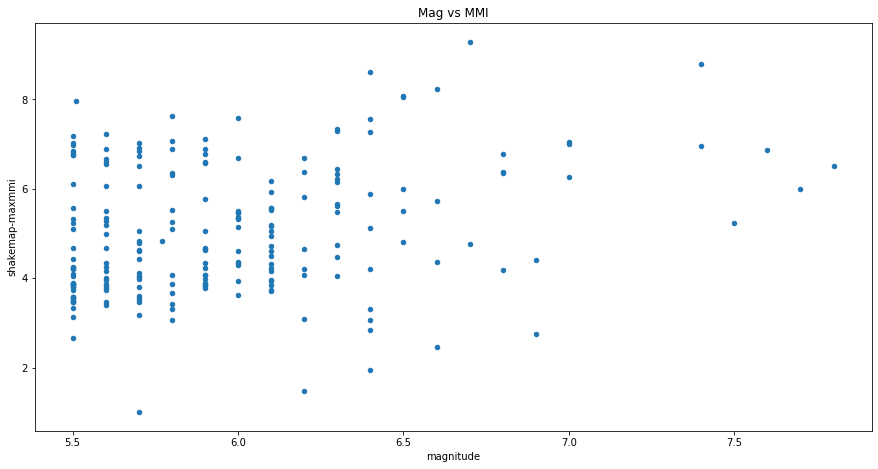

In [25]:
ax = sprops.plot(x='magnitude', y='shakemap-maxmmi', kind='scatter', figsize=(15,7.5), title = 'Mag vs MMI')

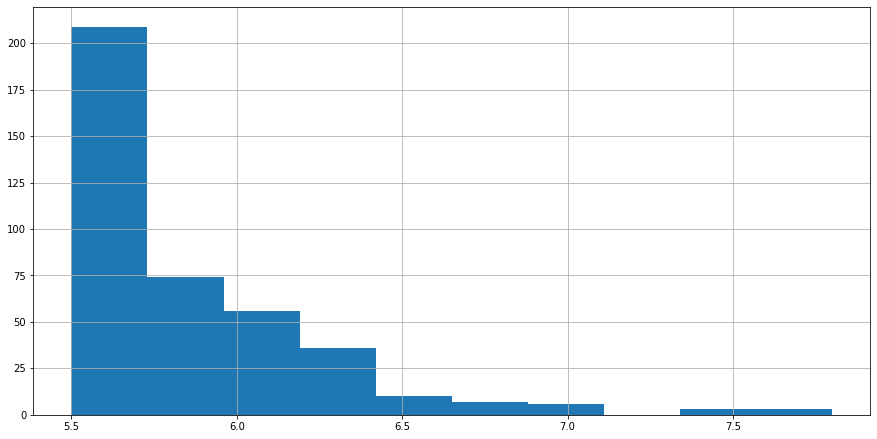

In [26]:
ax = props['magnitude'].hist(figsize=(15,7.5));
fig = ax.figure
fig.suptitle='Magnitude Frequency Distribution'


Of course, you can always plot the data using matplotlib functions!

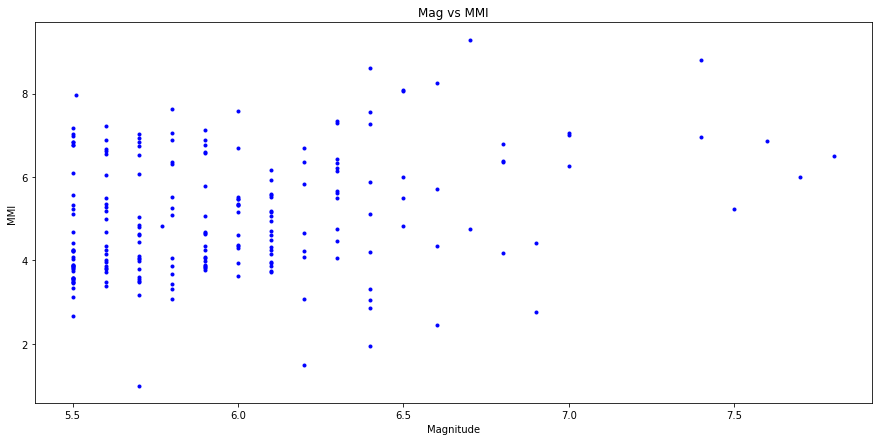

In [27]:
fig = plt.figure(figsize=(15,7))
plt.plot(sprops['magnitude'], sprops['shakemap-maxmmi'], 'b.')
tstring = plt.title('Mag vs MMI')
xlabel = plt.xlabel('Magnitude')
ylabel = plt.ylabel('MMI')


## Working with String Data <a name="working-with-string-data"></a>

Let's load in a new dataframe to explore what can be done with strings in pandas columns. This table contains earthquake "pick" information - that is, the time at which the earthquake wave ('P', 'S', or more exotic flavors like 'PKPdf') was detected at the station. 

In this case the arrival time information is split up into multiple **string** fields, instead of being in one datetime field as we might expect. Additionally, each date or time column is preceded by a character denoting what time unit is is ("Y" for "Year", etc.). Let's try to merge these columns into one 'Arrival Time' column which has a datetime type.

In [28]:
phases = pd.read_excel('us60007fd8_phases_broken.xlsx')
phases.head()

,Channel,Distance,Azimuth,Phase,Status,Residual,Weight,Agency,year,month,day,hour,minute,second
0,IM.ASAR.SHZ.F0,118.3170,260.1080,PKPdf,manual,0.6,0.00,idc,Y2020,m1,D25,H3,M22,S22
1,IM.CMAR.SHZ.F0,116.8020,321.5790,PKPdf,manual,0.7,0.00,idc,Y2020,m1,D25,H3,M22,S19
2,IM.WRA.BHZ.F0,116.0640,263.6780,PKPdf,manual,1.0,0.00,idc,Y2020,m1,D25,H3,M22,S18
3,IM.MKAR.SHZ.F0,96.6984,346.8520,P,manual,-0.4,0.77,idc,Y2020,m1,D25,H3,M17,S4
4,IM.AKASG.BHZ.F0,89.5316,20.6767,P,manual,0.0,0.92,idc,Y2020,m1,D25,H3,M16,S32


A Series object (remember that extracted rows and columns are Series) has an "accessor" called "str" that allows you to perform string operations on the fields in that Series. Let's use that to fix the date/time columns to be integers.

In [29]:
phases['year'] = phases['year'].str.replace('Y','')
phases['month'] = phases['month'].str.replace('m','')
phases['day'] = phases['day'].str.replace('D','')
phases['hour'] = phases['hour'].str.replace('H','')
phases['minute'] = phases['minute'].str.replace('M','')
phases['second'] = phases['second'].str.replace('S','')
phases.head()

,Channel,Distance,Azimuth,Phase,Status,Residual,Weight,Agency,year,month,day,hour,minute,second
0,IM.ASAR.SHZ.F0,118.3170,260.1080,PKPdf,manual,0.6,0.00,idc,2020,1,25,3,22,22
1,IM.CMAR.SHZ.F0,116.8020,321.5790,PKPdf,manual,0.7,0.00,idc,2020,1,25,3,22,19
2,IM.WRA.BHZ.F0,116.0640,263.6780,PKPdf,manual,1.0,0.00,idc,2020,1,25,3,22,18
3,IM.MKAR.SHZ.F0,96.6984,346.8520,P,manual,-0.4,0.77,idc,2020,1,25,3,17,4
4,IM.AKASG.BHZ.F0,89.5316,20.6767,P,manual,0.0,0.92,idc,2020,1,25,3,16,32


In [30]:
timecols = ['year', 'month', 'day', 'hour', 'minute', 'second']
phases['Arrival Time'] = pd.to_datetime(phases[timecols])
phases.head()

,Channel,Distance,Azimuth,Phase,Status,Residual,Weight,Agency,year,month,day,hour,minute,second,Arrival Time
0,IM.ASAR.SHZ.F0,118.3170,260.1080,PKPdf,manual,0.6,0.00,idc,2020,1,25,3,22,22,2020-01-25 03:22:22
1,IM.CMAR.SHZ.F0,116.8020,321.5790,PKPdf,manual,0.7,0.00,idc,2020,1,25,3,22,19,2020-01-25 03:22:19
2,IM.WRA.BHZ.F0,116.0640,263.6780,PKPdf,manual,1.0,0.00,idc,2020,1,25,3,22,18,2020-01-25 03:22:18
3,IM.MKAR.SHZ.F0,96.6984,346.8520,P,manual,-0.4,0.77,idc,2020,1,25,3,17,4,2020-01-25 03:17:04
4,IM.AKASG.BHZ.F0,89.5316,20.6767,P,manual,0.0,0.92,idc,2020,1,25,3,16,32,2020-01-25 03:16:32


Now let's get rid of our unnecessary date/time fields

In [31]:
phases = phases.drop(labels=timecols, axis='columns')
phases.head()

,Channel,Distance,Azimuth,Phase,Status,Residual,Weight,Agency,Arrival Time
0,IM.ASAR.SHZ.F0,118.3170,260.1080,PKPdf,manual,0.6,0.00,idc,2020-01-25 03:22:22
1,IM.CMAR.SHZ.F0,116.8020,321.5790,PKPdf,manual,0.7,0.00,idc,2020-01-25 03:22:19
2,IM.WRA.BHZ.F0,116.0640,263.6780,PKPdf,manual,1.0,0.00,idc,2020-01-25 03:22:18
3,IM.MKAR.SHZ.F0,96.6984,346.8520,P,manual,-0.4,0.77,idc,2020-01-25 03:17:04
4,IM.AKASG.BHZ.F0,89.5316,20.6767,P,manual,0.0,0.92,idc,2020-01-25 03:16:32


## Applying Functions to Data <a name="applying-functions-to-data"></a>

Most of the time, you should be able to perform vector operations on your pandas DataFrame. Sometimes, however, you may not be able to do this. Here we'll show the use of the DataFrame `apply()` method to all rows of our data. First, let's write a little function to calculate the average rate the wave traveled.   

In [32]:
def calc_rate(row):
    # hard coding event time b/c it's not in our data set
    # 2020-01-25 03:03:34.276
    event_time = datetime(2020,1,25,3,3,34)
    dt = row['Arrival Time'] - event_time
    rate = row['Distance']/dt.total_seconds()
    return rate


In [33]:
phases['Rate (deg/sec)'] = phases.apply(calc_rate, axis='columns')
phases.head()

,Channel,Distance,Azimuth,Phase,Status,Residual,Weight,Agency,Arrival Time,Rate (deg/sec)
0,IM.ASAR.SHZ.F0,118.3170,260.1080,PKPdf,manual,0.6,0.00,idc,2020-01-25 03:22:22,0.104891
1,IM.CMAR.SHZ.F0,116.8020,321.5790,PKPdf,manual,0.7,0.00,idc,2020-01-25 03:22:19,0.103824
2,IM.WRA.BHZ.F0,116.0640,263.6780,PKPdf,manual,1.0,0.00,idc,2020-01-25 03:22:18,0.103260
3,IM.MKAR.SHZ.F0,96.6984,346.8520,P,manual,-0.4,0.77,idc,2020-01-25 03:17:04,0.119381
4,IM.AKASG.BHZ.F0,89.5316,20.6767,P,manual,0.0,0.92,idc,2020-01-25 03:16:32,0.115079


## Resources <a name="resources"></a>

 - pandas Documentation: https://pandas.pydata.org/
 - pandas Read CSV: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
 - Excellent (4 hour) pandas tutorial from Scipy 2021: https://youtu.be/9dz1fmBUF8U?t=66